# Logistic Regression

In this notebook, we train Logistic Regression models to predict dry (0) or wet (1) for a given HJ Andrews HOBO Sensor Site 3 days after a given date. The model uses features at time t and the current wet/dry status (target[t]) to predict target[t+3]. We apply ADASYN to the training data.

We experiment with the following train-test-splitting strategies:
- Random
- Temporal
- Site-based

At the bottom of the notebook, we provide a function for practitioners to run inference with our trained models for an inputted site-date combination.

## Imports

In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
np.random.seed(42)

## Data Preprocessing

In [45]:
# Data Paths
DRIVERS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/drivers_xgb.csv"
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load drivers dataset as CSV
drivers = pd.read_csv(DRIVERS_PATH)

# Loads obs data
data = pd.read_parquet(OBS_PATH)

# Load in remaining datasets
static_df = pd.read_parquet(STATIC_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

data

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [46]:
# Isolate the target variable by creating dictionary of all metrics and choosing 'value'
dfs = {val: data[data['variable'] == val] for val in data['variable'].unique()}

wet_dry_df = dfs['HoboWetDry0.05']

In [47]:
# Make sure all NHD IDs are strings, normalize before merging
wet_dry_df = wet_dry_df.copy()
wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
drivers['NHDPlusID'] = drivers['NHDPlusID'].astype(str)
static_df['NHDPlusID'] = static_df['NHDPlusID'].astype(str)

# Make sure all date values are in datetime format, normalize before merging
wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])
drivers['Date'] = pd.to_datetime(drivers['Date'])

static_df_pivot = static_df.pivot(
    index='NHDPlusID',
    columns='variable',
    values='value'
).reset_index()

# Merge all datasets to create one central dataset
central_df = wet_dry_df.merge(drivers, on=['NHDPlusID', 'Date'], how='inner')
central_df = central_df.merge(static_df_pivot, on='NHDPlusID', how='left')
central_df = central_df.merge(degrees, on='NHDPlusID', how='left')

In [48]:
# Sort by date within each NHDPlusID
central_df = central_df.sort_values(['NHDPlusID', 'Date'])

# Target: wet/dry status 3 days ahead (target[t+3])
central_df['wet_dry_next'] = central_df.groupby('NHDPlusID')['value'].shift(-3)

# Drop rows with NaN values from target
central_df = central_df.dropna(subset=['wet_dry_next'])

## Random Split

In [49]:
def random_split(central_df):
    # Features and target
    X = central_df.drop('wet_dry_next', axis=1)
    y = central_df['wet_dry_next']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    return X_train, X_test, y_train, y_test

## Temporal Split

In [50]:
def temporal_split(central_df, split_date = '2020-9-15'):
    # Sort by time
    df = central_df.sort_values(['Date'])

    # Introduce temporal splitting
    # Every entry before 9/15 is training; rest is testing
    train = df[df['Date'] < split_date]
    test = df[df['Date'] >= split_date]

    X_train = train.drop('wet_dry_next', axis=1)
    y_train = train['wet_dry_next']
    X_test = test.drop('wet_dry_next', axis=1)
    y_test = test['wet_dry_next']

    return X_train, X_test, y_train, y_test

## Site-Based Split

In [51]:
def site_split(central_df):
    # Sort data chronologically
    central_df = central_df.sort_values(['Date']).reset_index(drop=True)

    # Split sites into train and test groups
    sites = central_df['SiteIDCode'].unique()
    train_sites = sites[:int(0.8 * len(sites))]
    test_sites  = sites[int(0.8 * len(sites)):]

    # Create site-based train and test sets
    train = central_df[central_df['SiteIDCode'].isin(train_sites)].copy()
    test  = central_df[central_df['SiteIDCode'].isin(test_sites)].copy()

    # Features and target
    X_train = train.drop('wet_dry_next', axis=1)
    y_train = train['wet_dry_next']
    X_test = test.drop('wet_dry_next', axis=1)
    y_test = test['wet_dry_next']

    return X_train, X_test, y_train, y_test

## ADASYN Resampling and Model Training

In [52]:
X_train, X_test, y_train, y_test = temporal_split(central_df)

# Drop non-numerical, non-influential columns
X_train = X_train.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis=1)
X_test = X_test.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis=1)

In [53]:
# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Apply ADASYN to fix class imbalance
adasyn = ADASYN(random_state=42)
X_train_re, y_train_re = adasyn.fit_resample(X_train_scaled, y_train)

In [55]:
# Define Logistic Regression model and fit it on training data
LR_model = LogisticRegression(
    max_iter=3000,
    random_state=42
)

LR_model.fit(X_train_re, y_train_re)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

## Metrics and Feature Importance - Temporal Split

In [56]:
# Apply model onto test data and save predictions
y_pred = LR_model.predict(X_test_scaled)

# Obtain performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9324
ROC-AUC: 0.9044
F1 Score: 0.9573


In [57]:
# Print classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.820     0.857     0.838       154
         1.0      0.963     0.952     0.957       600

    accuracy                          0.932       754
   macro avg      0.891     0.904     0.898       754
weighted avg      0.934     0.932     0.933       754



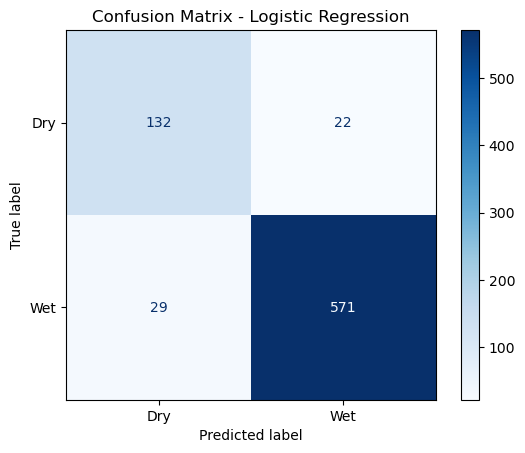

In [58]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [59]:
# Make feature importances table (coefficients)
feature_cols = X_train.columns.tolist()

coefficients = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": LR_model.coef_[0]
})

# Sort by absolute value to see most important features
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']].to_string(index=False))

       Feature  Coefficient
    Out-degree     4.086620
         value     3.293540
         Slope    -3.153357
 aspect_se_pct     2.852928
 aspect_ne_pct    -2.657167
           sph     2.485160
         rhmax    -1.952305
         rhmin     1.923752
   elev_min_cm    -1.595249
          srad     1.562694
  slp_mean_pct     1.511324
     curv_mean     1.511324
          prcp     1.264899
elev_median_cm    -1.171457
      FromNode     1.066892
  elev_mean_cm    -1.025695
          tmin    -0.908370
            ws     0.799907
            vp     0.787885
        ToNode     0.736775
   elev_max_cm     0.667143
   curv_median     0.601615
slp_median_pct     0.601615
     etalfalfa    -0.555492
     In-degree     0.469594
      AreaSqKm     0.457916
    ArbolateSu    -0.377458
     TotDASqKm     0.207935
          tmax    -0.181141
      LengthKM    -0.105888
       etgrass     0.026404
 aspect_sw_pct     0.017503
 aspect_nw_pct    -0.016998


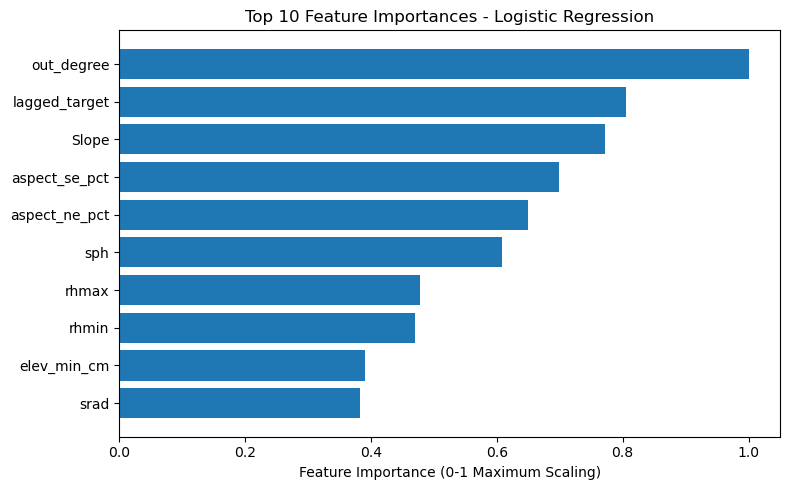

In [60]:
# Rename features for visualization
importance = coefficients[['Feature', 'Abs_Coefficient']].copy()
importance['Feature'] = importance['Feature'].replace({
    'Out-degree': 'out_degree',
    'In-degree': 'in_degree',
    'value': 'lagged_target',
})

# Scale to 0-1
importance['Importance'] = importance['Abs_Coefficient'] / importance['Abs_Coefficient'].max()

# Plot top 10
top10 = importance.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Importance'][::-1])
ax.set_xlabel('Feature Importance (0-1 Maximum Scaling)')
ax.set_title('Top 10 Feature Importances - Logistic Regression')
plt.tight_layout()
plt.show()

## Comparison Across Split Strategies

In [61]:
# Train and evaluate Logistic Regression with each split strategy
drop_cols = ['variable', 'NHDPlusID', 'SiteIDCode', 'Date']
splits = {
    'Random': random_split(central_df),
    'Temporal': temporal_split(central_df),
    'Site-Based': site_split(central_df),
}

split_data = {}
results = []

for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    X_tr = X_tr.drop(drop_cols, axis=1)
    X_te = X_te.drop(drop_cols, axis=1)

    # Scale
    scaler_split = StandardScaler()
    X_tr_scaled = scaler_split.fit_transform(X_tr)
    X_te_scaled = scaler_split.transform(X_te)

    # ADASYN
    adasyn = ADASYN(random_state=42)
    X_tr_res, y_tr_res = adasyn.fit_resample(X_tr_scaled, y_tr)

    # Train
    model = LogisticRegression(max_iter=3000, random_state=42)
    model.fit(X_tr_res, y_tr_res)

    # Predict
    y_pred = model.predict(X_te_scaled)

    split_data[name] = (y_te, y_pred)
    results.append({
        'Split': name,
        'Accuracy': accuracy_score(y_te, y_pred),
        'ROC-AUC': roc_auc_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred),
    })

# Display metrics table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

     Split  Accuracy  ROC-AUC       F1
    Random  0.949904 0.961292 0.968293
  Temporal  0.932361 0.904405 0.957251
Site-Based  0.795812 0.716269 0.862191


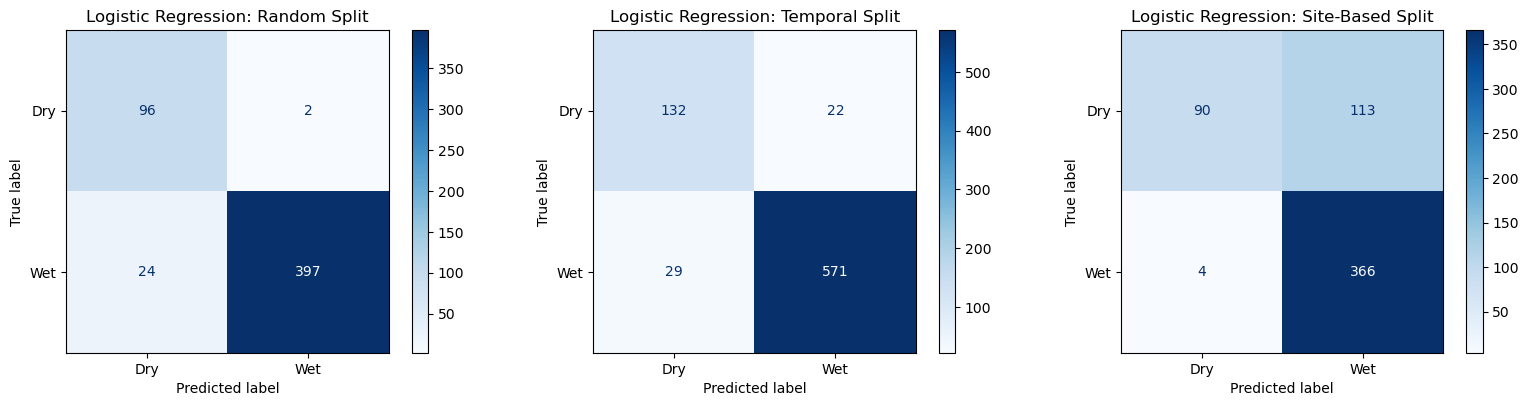


Random Split
              precision    recall  f1-score   support

         Dry      0.800     0.980     0.881        98
         Wet      0.995     0.943     0.968       421

    accuracy                          0.950       519
   macro avg      0.897     0.961     0.925       519
weighted avg      0.958     0.950     0.952       519


Temporal Split
              precision    recall  f1-score   support

         Dry      0.820     0.857     0.838       154
         Wet      0.963     0.952     0.957       600

    accuracy                          0.932       754
   macro avg      0.891     0.904     0.898       754
weighted avg      0.934     0.932     0.933       754


Site-Based Split
              precision    recall  f1-score   support

         Dry      0.957     0.443     0.606       203
         Wet      0.764     0.989     0.862       370

    accuracy                          0.796       573
   macro avg      0.861     0.716     0.734       573
weighted avg      0.833   

In [62]:
# Confusion matrices and classification reports
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, (y_te, y_p)) in zip(axes, split_data.items()):
    cm = confusion_matrix(y_te, y_p, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    ax.set_title(f'Logistic Regression: {name} Split')

plt.tight_layout()
plt.show()

for name, (y_te, y_p) in split_data.items():
    print(f"\n{'='*50}")
    print(f"{name} Split")
    print('='*50)
    print(classification_report(y_te, y_p, target_names=['Dry', 'Wet'], digits=3))

## Inference

In [63]:
def predict_site_date(model, scaler, central_df, feature_cols, site_id, date, days_ahead=3):
    """
    Predict wet/dry status for a given site on day n+days_ahead given its wet/dry status and features on day n.
    
    Parameters:
    -----------
    model : LogisticRegression
        Trained logistic regression model
    scaler : StandardScaler
        Fitted scaler for feature normalization
    central_df : pd.DataFrame
        Complete dataset with all features
    feature_cols : list
        List of feature column names used in training
    site_id : str
        Site identifier (e.g., "HoboSite100")
    date : str
        Date in format "YYYY-MM-DD"
    
    Returns:
    --------
    str : Prediction result with probability
    """
    date = pd.to_datetime(date)
    site_id = str(site_id)
    
    row = central_df[(central_df["SiteIDCode"] == site_id) & (central_df["Date"] == date)]
    
    if row.empty:
        return f"No data found for Site {site_id} on {date.date()}"
    
    Xq = row[feature_cols]
    Xq_scaled = scaler.transform(Xq)
    
    pred_class = model.predict(Xq_scaled)
    pred_prob = model.predict_proba(Xq_scaled)[:, 1]
    
    return f"Site {site_id} on {(date + pd.Timedelta(days=days_ahead)).date()} (predicted from {date.date()}): {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={pred_prob[0]:.4f})"

In [64]:
# Example inference
predict_site_date(
    model=LR_model,
    scaler=scaler,
    central_df=central_df,
    feature_cols=feature_cols,
    site_id="HoboSite100",
    date="2020-10-22"
)

'Site HoboSite100 on 2020-10-25 (predicted from 2020-10-22): DRY, (P(wet)=0.0000)'